In [1]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
import copy
import pandas as pd
import math


In [2]:
class Plot_Arguments():
    def __init__(self):
        self.epochs = 100
        self.legends = ["Main task - Black box", "Main task - Model Replacement", "Attack success rate - black box",
                        "Attack success rate - model replacement"]
        self.maxy = 110
        self.ylabel = 'Accuracy (%)'
        self.xlabel = 'FL rounds'
        self.colors = ['black',
                       '#339933',
                       '#fdae61',
                       '#d7191c', '#000000', '#B03A2E', '#85C1E9']
        self.patterns = ['x', 'o', 'd', 'v', '^', '<', '>']

In [3]:
def generate_histogram(plot_config, experiment_name, y_label, column_name, min_y, max_y, average=False, display_err = True, extension="pdf"):

    labels = []
    colors = []
    values = []
    errs = []
    
    for exp in plot_config["data"]:
        labels.append(exp["exp_name"])
        colors.append(exp["color"])
        if exp["file_path"] is None:

            values.append(-1)
            errs.append(-1)
        else:
            if average:
                max_value, std_dev = get_max_average(exp["file_path"],column_name)
                values.append(max_value)
                errs.append(std_dev)
            else:
                values.append(get_max_avg_value(exp["file_path"],column_name))
                errs.append(get_std_dev_value(exp["file_path"], column_name))
        
    # the histogram of the data

    plot_args = Plot_Arguments()
    fig, ax = plt.subplots()

    plot_args.ylabel= y_label

    s1 = plt.bar(labels,values, color=colors, width= 0.35, yerr=errs)
    plt.xticks(rotation=-90)

    plt.ylabel(plot_args.ylabel)

    rects = ax.patches 

    for rect, label, err in zip(rects, values, errs):
        if label == -1:
            label = "N/A"
            ax.text(
                rect.get_x() + rect.get_width() / 2, min_y + 0.03*(max_y-min_y), label,ha="center")
        else:
            height = rect.get_height()+ 0.03*(max_y-min_y)
            width = rect.get_x() + rect.get_width() / 2
            
            if not math.isnan(err) or err !=0 :
                print("err")
                print(err)
                if height+err >=max_y-0.05*(max_y-min_y) and label !=100:
                    
                    width+=0.3
                    height -= 0.03*(max_y-min_y)
                else:
                    height+=err
            if label %1 < 0.1:
                label = '%.0f'%label
            else:
                label = '%.1f'%label
            ax.text(
               width , height, label , ha="center", va="bottom"
            )

    # plt.xlabel(plot_args.xlabel)

    # def addlabels(x,y):
    #     for i in range(len(x)):
    #         plt.text(i-0.25,y[i]+0.25,y[i])
    # plt.ylabel('Main task accuracy (%)', fontsize=16)
    ax.set_ylim(min_y, max_y)
    
    max_tick = max_y if max_y <=100 else 100
    plt.yticks(np.arange(min_y, max_tick+1, (max_tick - min_y)/4))
#     ax.autoscale(axis="both")



    plt.savefig('./figures/{}_{}.{}'.format(plot_config['dataset_name'], experiment_name, extension),bbox_inches='tight')

    plt.show()
    

In [4]:
def generate_xy_plot(plot_config, experiment_name, y_label, column_name, min_y, max_y, average=False):
    
    labels = []
    colors = []
    values = []
    markers = []
    
    for exp in plot_config["data"]:
        
        if exp["file_path"] is None:
            continue
            
        labels.append(exp["exp_name"])
        colors.append(exp["color"])
        markers.append(exp["symbol"])
        if average:
            values.append(compute_average_per_round(exp["file_path"],column_name))
        else:
            values.append(get_max_avg_value(exp["file_path"],column_name))
    
    
    plot_args = Plot_Arguments()
    fig, ax = plt.subplots()
    plot_args.ylabel= y_label

    x = range(1, len(values[0]) + 1)
    
    for i in range(len(labels)):
        print(labels[i])
        print(len(values[i]))
        ax.plot(x, values[i], color= colors[i] ,label=labels[i], linewidth=1, marker=markers[i], markersize=6, markevery=5+i)
            
    plt.ylabel(plot_args.ylabel)
    plt.xlabel(plot_args.xlabel)
    
    # plt.subplots_adjust(top=0.75)
    lgd = ax.legend(ncol=3, loc="lower center", bbox_to_anchor=[0.5, -0.55])
    ax.set_xlim(1, len(values[0])+1)
    ax.set_ylim(0, 100)
    
    plt.savefig('./figures/{}_{}.pdf'.format(plot_config['dataset_name'], experiment_name),bbox_inches='tight')

    plt.show()
    

        

In [5]:
def generate_tradeoff_plot(plot_config, experiment_name, x_label, y_label, x_column_name, y_column_name, min_y, max_y, min_x, max_x, average=False):
    
    labels = []
    colors = []
    values = []
    markers = []
    x_values = []
    y_values = []
    
    for exp in plot_config["data"]:
        if exp["file_path"] is None:
            continue
        labels.append(exp["exp_name"])
        colors.append(exp["color"])
        markers.append(exp["symbol"])
        if average:
            x_values.append(get_max_average(exp["file_path"],x_column_name))
            y_values.append(get_max_average(exp["file_path"],y_column_name))
        else:
            x_values.append(get_max_avg_value(exp["file_path"],x_column_name))
            y_values.append(get_max_avg_value(exp["file_path"],y_column_name))

        
    
    
    plot_args = Plot_Arguments()
    fig, ax = plt.subplots()
    plot_args.xlabel = x_label
    plot_args.ylabel= y_label
    
    for i in range(len(labels)):
        ax.plot(x_values[i], y_values[i], color= colors[i] ,label=labels[i], linewidth=1, marker=markers[i], linestyle='None', markersize=6, markevery=5+i)
            
    plt.ylabel(plot_args.ylabel)
    plt.xlabel(plot_args.xlabel)
    plt.subplots_adjust(top=0.75)
    lgd = ax.legend(ncol=4, loc="lower center", bbox_to_anchor=[0.5, -0.6])
    ax.set_xlim(min_x, max_x)
    ax.set_ylim(min_y, max_y)
    
#     for i, txt in enumerate(labels):
#         ax.annotate(txt, (x_values[i] + 2 , y_values[i] -1), fontsize=8)
    
    plt.savefig('./figures/{}_{}.pdf'.format(plot_config['dataset_name'], experiment_name),bbox_inches='tight')

    plt.show()
    

In [6]:
def compute_average_per_round(file_path, column_name):
    data = pd.read_csv(file_path)
    columns_to_aggregate = data.columns[data.columns.str.contains(column_name)]
    
    values = data[columns_to_aggregate].mean(axis=1)
    return values.to_list()

def compute_average(file_path, column_name):
    return compute_average_per_round(file_path, column_name)[-1]
   
    
def get_max_average(file_path, column_name):
    data = pd.read_csv(file_path)
    columns_to_aggregate = data.columns[data.columns.str.contains(column_name)]
    
    maxs = []
    for column in columns_to_aggregate:
        maxs.append(max(data[column].to_list()))
        
    std_dev = np.std(maxs)
    
    return sum(maxs)/len(maxs), std_dev

def get_max_values_per_client(file_path, column_name):
    
    data = pd.read_csv(file_path)
    values = []
    
    columns_to_compute = data.columns[data.columns.str.contains(column_name)]
    
    for column in columns_to_compute:
        values.append(max(data[column].to_list()))
        
    return values



def get_max_avg_value(file_path, column_name):
    data = pd.read_csv(file_path)
    columns_to_aggregate = data.columns[data.columns.str.contains(column_name)]
    
    values = data[columns_to_aggregate].mean(axis=1)
    return sum(values.to_list()[-10:])/10


def get_std_dev_value(file_path, column_name):
    data = pd.read_csv(file_path)
    columns_to_aggregate = data.columns[data.columns.str.contains(column_name)]
    
    values = data[columns_to_aggregate].std(axis=1)
    return values.to_list()[-1]


### Speech Commands

In [7]:
plot_config = {
                "dataset_name": "speechcommands",
                "dataset_pretty_name" : "Speech Commands",

                "data":[
                        {
                            "exp_name" : "No defense",
                            "file_path": "ppm_baseline_speechcommands.csv",
                            "color": "black",
                            "symbol" : "+"
                        },
                                                                                      {
                            "exp_name" : "PASTEL - Conv",
                            "file_path": "ppm_conv_speechcommands.csv",
                            "color": "lightseagreen",
                            "symbol" : "s"
                        },
                                                 {
                            "exp_name" : "PASTEL - Linear",
                            "file_path": "ppm_fc1_speechcommands.csv",
                            "color": "brown",
                            "symbol" : "x"
                        },
                                            
                         {
                            "exp_name" : "PASTEL - All BN",
                            "file_path": "ppm_bn_speechcommands.csv",
                            "color": "blue",
                            "symbol" : "v"
                        },
                          {
                            "exp_name" : "PASTEL - First BN",
                            "file_path": "ppm_bn1_speechcommands.csv",
                            "color": "orange",
                            "symbol" : "D"
                        },
                                              {
                            "exp_name" : "PASTEL - Last BN",
                            "file_path": "ppm_bn17_speechcommands.csv",
                            "color": "grey",
                            "symbol" : "*"
                        },
                         {
                            "exp_name" : "RelaxLoss",
                            "file_path": "ppm_speechcommands_relaxloss.csv",
                            "color": "red",
                            "symbol" : ">"
                        },
                                                                     {
                            "exp_name" : "GNL",
                            "file_path": "ppm_gnl_speechcommands.csv",
                            "color": "lime",
                            "symbol" : "H"
                        },
                                                                         {
                            "exp_name" : "ANL",
                            "file_path": "ppm_ANL_speechcommands.csv",
                            "color": "magenta",
                            "symbol" : "X"
                        }
                    ]
                }
            


err
7.105427357601002e-15
err
0.2182027881293102
err
0.8593874055411627
err
0.0
err
0.0
err
0.0
err
1.3446806646804275
err
0.5292810296095081
err
0.0


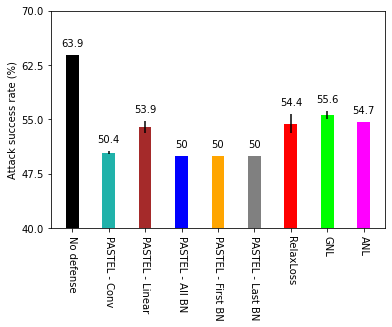

err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0


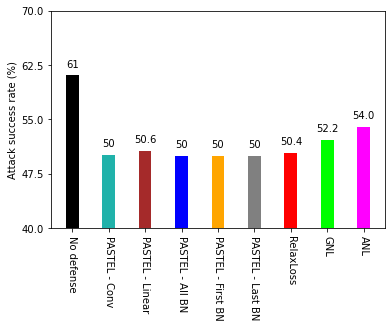

No defense
80
PASTEL - Conv
80
PASTEL - Linear
80
PASTEL - All BN
80
PASTEL - First BN
80
PASTEL - Last BN
80
RelaxLoss
80
GNL
80
ANL
80


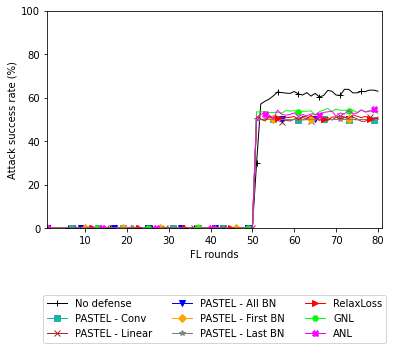

No defense
80
PASTEL - Conv
80
PASTEL - Linear
80
PASTEL - All BN
80
PASTEL - First BN
80
PASTEL - Last BN
80
RelaxLoss
80
GNL
80
ANL
80


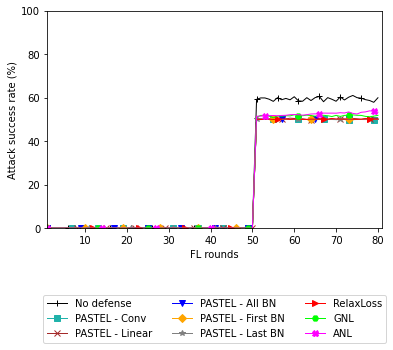

No defense
80
PASTEL - Conv
80
PASTEL - Linear
80
PASTEL - All BN
80
PASTEL - First BN
80
PASTEL - Last BN
80
RelaxLoss
80
GNL
80
ANL
80


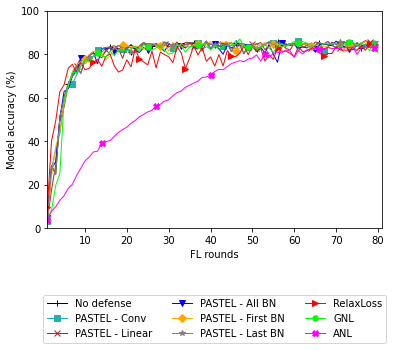

err
0.8365359451591156
err
1.2126210566329487
err
0.719861578389567
err
1.20345523318065
err
1.1294117647058834
err
0.8365359451591156
err
0.9690004838575988
err
0.982617083191582
err
0.0


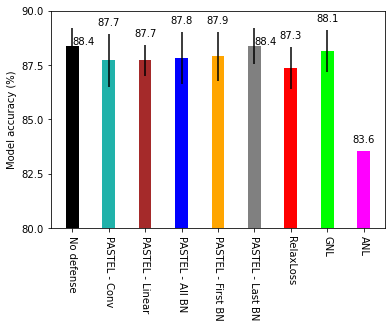

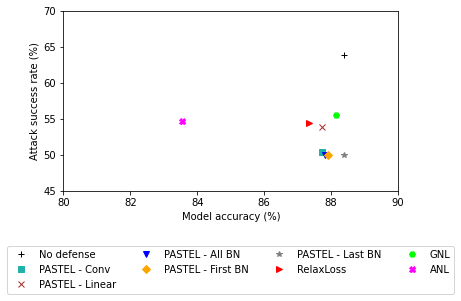

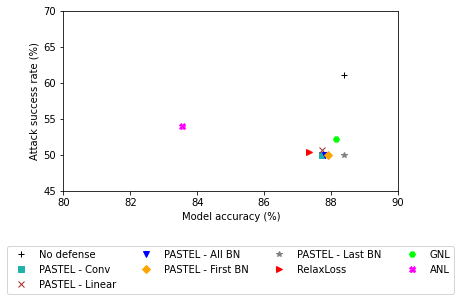

In [8]:
generate_histogram(plot_config, "local_model_attack_accuracy_hist", "Attack success rate (%)", "client_attack", 40, 70, average=True)
generate_histogram(plot_config, "global_model_attack_accuracy_hist", "Attack success rate (%)", "server_attack", 40, 70, average=True)
generate_xy_plot(plot_config, 'local_models_attack_accuracy', 'Attack success rate (%)', 'client_attack', 0, 100, average=True)
generate_xy_plot(plot_config, 'global_model_attack_accuracy', 'Attack success rate (%)', 'server_attack', 0, 100, average=True)
generate_xy_plot(plot_config, 'local_models_accuracy', 'Model accuracy (%)', 'client_accuracy', 0, 100, average=True)
generate_histogram(plot_config, "local_models_accuracy_hist", "Model accuracy (%)", "client_accuracy", 80, 90, average=True)
generate_tradeoff_plot(plot_config, 'attack_accuracy_tradeoff_client', 'Model accuracy (%)', 'Attack success rate (%)', 'client_accuracy', 'client_attack', 45, 70, 80, 90, average=True)
generate_tradeoff_plot(plot_config, 'attack_accuracy_tradeoff_server', 'Model accuracy (%)', 'Attack success rate (%)', 'client_accuracy', 'server_attack', 45, 70, 80, 90, average=True)


### Purchase 100

In [9]:
plot_config = {
                "dataset_name": "purchase",
                "dataset_pretty_name" : "Purchase 100",

                "data":[

                        {
                            "exp_name" : "No defense",
                            "file_path": "ppm_baseline_purchase.csv",
                            "color": "black",
                            "symbol" : "+"
                        },
                                                                                      {
                            "exp_name" : "PASTEL - Conv",
                            "file_path": None,
                            "color": "lightseagreen",
                            "symbol" : "s"
                        },
                            {
                            "exp_name" : "PASTEL - Linear",
                            "file_path": "ppm_fc1_purchase.csv",
                            "color": "brown",
                            "symbol" : "x"
                        },
                                      
                                             {
                            "exp_name" : "PASTEL - All BN",
                            "file_path": None,
                            "color": "blue",
                            "symbol" : "v"
                        },
                          {
                            "exp_name" : "PASTEL - First BN",
                            "file_path": None,
                            "color": "orange",
                            "symbol" : "D"
                        },
                                              {
                            "exp_name" : "PASTEL - Last BN",
                            "file_path": None,
                            "color": "grey",
                            "symbol" : "*"
                        },
                               {
                            "exp_name" : "RelaxLoss",
                            "file_path": "ppm_relaxloss_purchase.csv",
                            "color": "red",
                            "symbol" : ">"
                        },
                                                                     {
                            "exp_name" : "GNL",
                            "file_path": "ppm_gnl_purchase.csv",
                            "color": "lime",
                            "symbol" : "H"
                        },
                                                                         {
                            "exp_name" : "ANL",
                            "file_path": None,
                            "color": "magenta",
                            "symbol" : "X"
                        }
                    ]
                }

err
1.7876698047733703
err
0.6685054990835956
err
1.278835096088143
err
1.4472363807583175


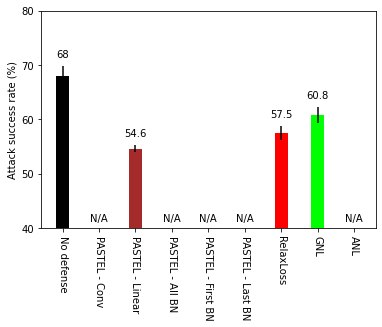

err
0.0
err
0.0
err
0.0
err
0.0


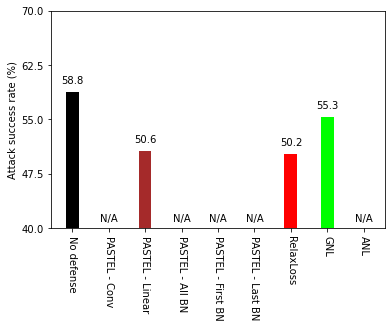

No defense
130
PASTEL - Linear
130
RelaxLoss
130
GNL
130


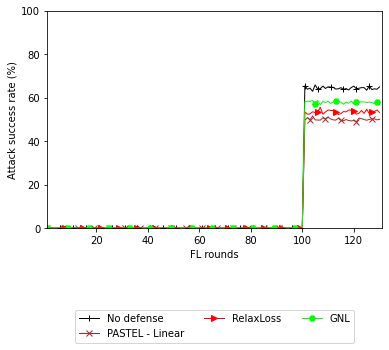

No defense
130
PASTEL - Linear
130
RelaxLoss
130
GNL
130


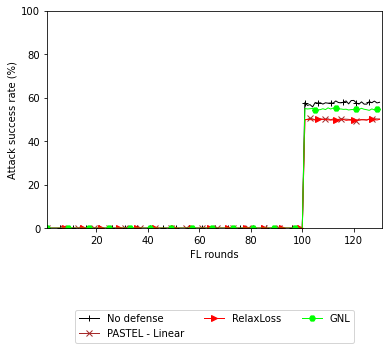

No defense
130
PASTEL - Linear
130
RelaxLoss
130
GNL
130


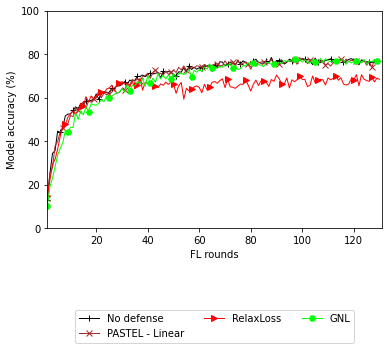

err
2.404325431546398
err
2.2527026576666627
err
2.7709110809422888
err
3.267241046088034


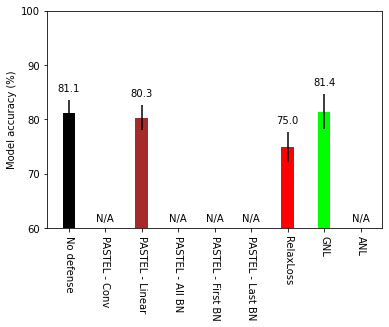

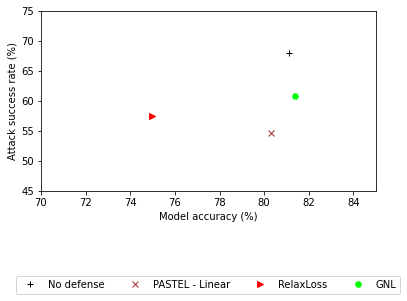

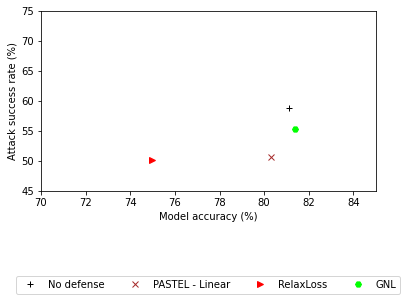

In [10]:
generate_histogram(plot_config, "local_model_attack_accuracy_hist", "Attack success rate (%)", "client_attack", 40, 80, average=True)
generate_histogram(plot_config, "global_model_attack_accuracy_hist", "Attack success rate (%)", "server_attack", 40, 70, average=True)
generate_xy_plot(plot_config, 'local_models_attack_accuracy', 'Attack success rate (%)', 'client_attack', 0, 100, average=True)
generate_xy_plot(plot_config, 'global_model_attack_accuracy', 'Attack success rate (%)', 'server_attack', 0, 100, average=True)
generate_xy_plot(plot_config, 'local_models_accuracy', 'Model accuracy (%)', 'client_accuracy', 40, 70, average=True)
generate_histogram(plot_config, "local_models_accuracy_hist", "Model accuracy (%)", "client_accuracy", 60, 100, average=True)
generate_tradeoff_plot(plot_config, 'attack_accuracy_tradeoff_client', 'Model accuracy (%)', 'Attack success rate (%)', 'client_accuracy', 'client_attack', 45, 75, 70, 85, average=True)
generate_tradeoff_plot(plot_config, 'attack_accuracy_tradeoff_server', 'Model accuracy (%)', 'Attack success rate (%)', 'client_accuracy', 'server_attack', 45, 75, 70, 85, average=True)


### Texas 100

In [11]:
plot_config = {
                "dataset_name": "texas",
                "dataset_pretty_name" : "Texas100",

                "data":[

                        {
                            "exp_name" : "No defense",
                            "file_path": "ppm_baseline_texas.csv",
                            "color": "black",
                            "symbol" : "+"
                        },
                                                                                      {
                            "exp_name" : "PASTEL - Conv",
                            "file_path": None,
                            "color": "lightseagreen",
                            "symbol" : "s"
                        },
                    
                                                 {
                            "exp_name" : "PASTEL - Linear",
                            "file_path": "ppm_linear1_texas.csv",
                            "color": "brown",
                            "symbol" : "x"
                        },

                                                                 {
                            "exp_name" : "PASTEL - All BN",
                            "file_path": None,
                            "color": "blue",
                            "symbol" : "v"
                        },
                          {
                            "exp_name" : "PASTEL - First BN",
                            "file_path": None,
                            "color": "orange",
                            "symbol" : "D"
                        },
                                              {
                            "exp_name" : "PASTEL - Last BN",
                            "file_path": None,
                            "color": "grey",
                            "symbol" : "*"
                        },

                                                                     {
                            "exp_name" : "RelaxLoss",
                            "file_path": "ppm_relaxloss_texas.csv",
                            "color": "red",
                            "symbol" : ">"
                        },
                                                                     {
                            "exp_name" : "GNL",
                            "file_path": "ppm_gnl_texas.csv",
                            "color": "lime",
                            "symbol" : "H"
                        },
                                                                         {
                            "exp_name" : "ANL",
                            "file_path": None,
                            "color": "magenta",
                            "symbol" : "X"
                        }
                    ]
                }

err
1.9161727211177977
err
1.1440677966101693
err
1.072795669590865
err
1.5632090462454837


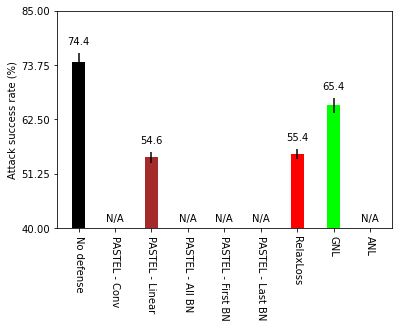

err
0.0
err
0.0
err
0.0
err
0.0


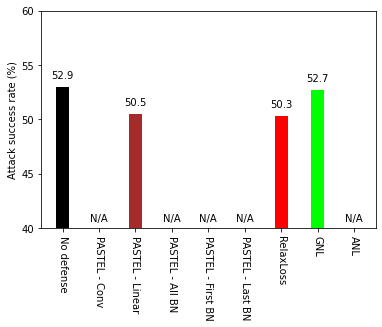

No defense
550
PASTEL - Linear
550
RelaxLoss
550
GNL
550


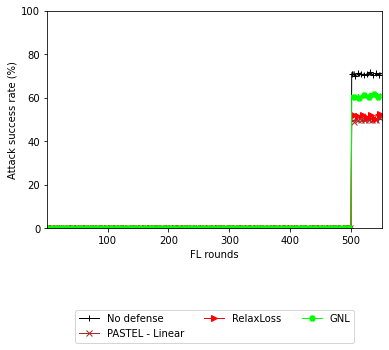

No defense
550
PASTEL - Linear
550
RelaxLoss
550
GNL
550


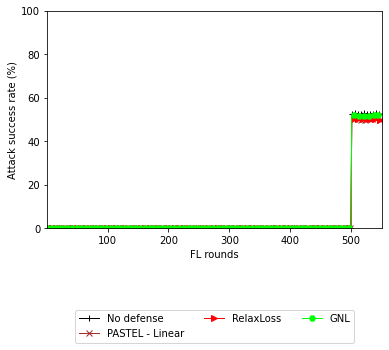

No defense
550
PASTEL - Linear
550
RelaxLoss
550
GNL
550


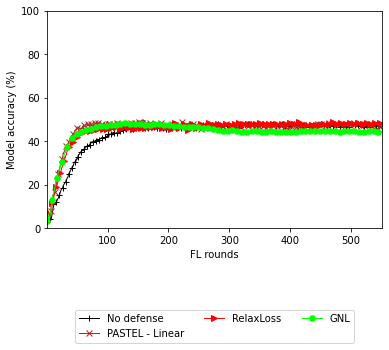

err
5.316741403850209
err
4.173244831269535
err
4.602092875384904
err
3.3696432800120393


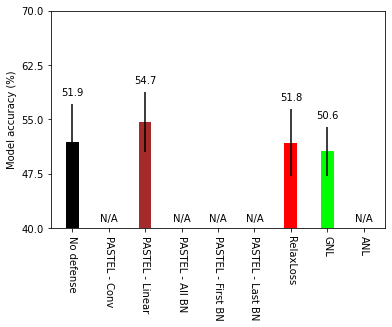

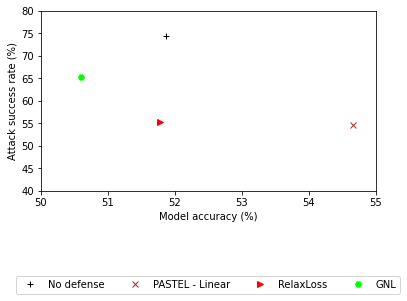

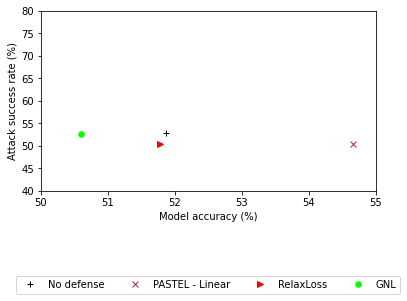

In [12]:
generate_histogram(plot_config, "local_model_attack_accuracy_hist", "Attack success rate (%)", "client_attack", 40, 85, average=True)
generate_histogram(plot_config, "global_model_attack_accuracy_hist", "Attack success rate (%)", "server_attack", 40, 60, average=True)
generate_xy_plot(plot_config, 'local_models_attack_accuracy', 'Attack success rate (%)', 'client_attack', 0, 80, average=True)
generate_xy_plot(plot_config, 'global_model_attack_accuracy', 'Attack success rate (%)', 'server_attack', 0, 60, average=True)
generate_xy_plot(plot_config, 'local_models_accuracy', 'Model accuracy (%)', 'client_accuracy', 35, 50, average=True)
generate_histogram(plot_config, "local_models_accuracy_hist", "Model accuracy (%)", "client_accuracy", 40, 70, average=True)
generate_tradeoff_plot(plot_config, 'attack_accuracy_tradeoff', 'Model accuracy (%)', 'Attack success rate (%)', 'client_accuracy', 'client_attack', 40, 80, 50, 55, average=True)
generate_tradeoff_plot(plot_config, 'attack_accuracy_tradeoff_server', 'Model accuracy (%)', 'Attack success rate (%)', 'client_accuracy', 'server_attack',40, 80, 50, 55, average=True)


### Celeba VGG

In [13]:
plot_config = {
                "dataset_name": "celeba_vgg",
                "dataset_pretty_name" : "CelebA",

                "data":[

                        {
                            "exp_name" : "No defense",
                            "file_path": "ppm_baseline_celeba_vgg.csv",
                            "color": "black",
                            "symbol" : "+"
                        },
                    
                                                 {
                            "exp_name" : "PASTEL - Conv.",
                            "file_path": "ppm_conv_celeba_vgg.csv",
                            "color": "lightseagreen",
                            "symbol" : "s"
                        },
                                                                     {
                            "exp_name" : "PASTEL - Linear",
                            "file_path": "ppm_linear_celeba_vgg.csv",
                            "color": "brown",
                            "symbol" : "x"
                        },
                                                                     {
                            "exp_name" : "PASTEL - All BN",
                            "file_path": "ppm_bn_celeba_vgg.csv",
                            "color": "blue",
                            "symbol" : "v"
                        },
                                              {
                            "exp_name" : "PASTEL - First BN",
                            "file_path": "ppm_first-bn_celeba_vgg.csv",
                            "color": "orange",
                            "symbol" : "D"
                        },
                                              {
                            "exp_name" : "PASTEL - Last BN",
                            "file_path": "ppm_last-bn_celeba_vgg.csv",
                            "color": "grey",
                            "symbol" : "*"
                        },
                                           {
                            "exp_name" : "Relaxloss(α=0.1) ",
                            "file_path": "ppm_relaxloss_alpha01_celeba_vgg.csv",
                            "color": "red",
                            "symbol" : ">"
                        },
                                                                     {
                            "exp_name" : "GNL",
                            "file_path": "ppm_gnl_celeba_vgg.csv",
                            "color": "lime",
                            "symbol" : "H"
                        },
                                                                         {
                            "exp_name" : "ANL",
                            "file_path": "ppm_anl_celeba_vgg.csv",
                            "color": "magenta",
                            "symbol" : "X"
                        }
                    ]
                }

err
1.1737877907772676
err
0.1632993161855429
err
0.9043106644166998
err
0.0
err
0.0
err
0.0
err
1.2543258481484505
err
1.0954451150103344
err
1.3564659966250574


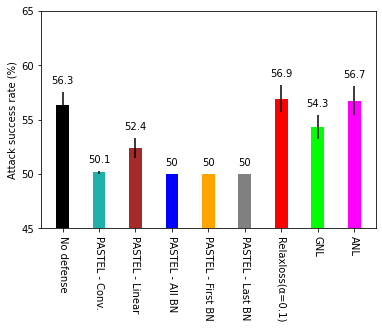

err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0


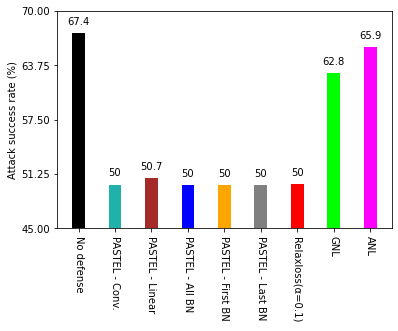

No defense
50
PASTEL - Conv.
50
PASTEL - Linear
50
PASTEL - All BN
50
PASTEL - First BN
50
PASTEL - Last BN
50
Relaxloss(α=0.1) 
50
GNL
50
ANL
50


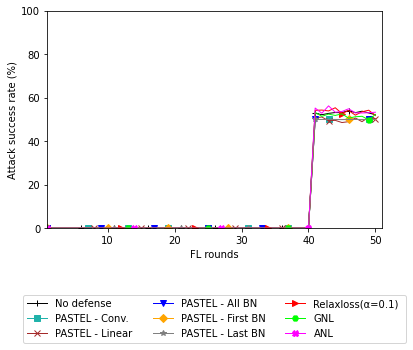

No defense
50
PASTEL - Conv.
50
PASTEL - Linear
50
PASTEL - All BN
50
PASTEL - First BN
50
PASTEL - Last BN
50
Relaxloss(α=0.1) 
50
GNL
50
ANL
50


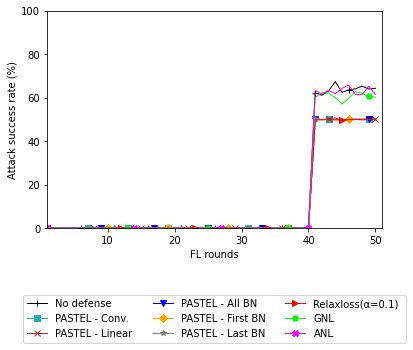

No defense
50
PASTEL - Conv.
50
PASTEL - Linear
50
PASTEL - All BN
50
PASTEL - First BN
50
PASTEL - Last BN
50
Relaxloss(α=0.1) 
50
GNL
50
ANL
50


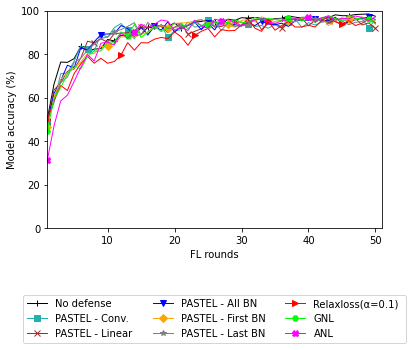

err
0.3265986323710997
err
0.6531972647421784
err
0.7774602526460369
err
0.5333333333333229
err
0.4216370213557779
err
0.49888765156984877
err
0.8432740427115558
err
0.2666666666666515
err
0.3265986323710997


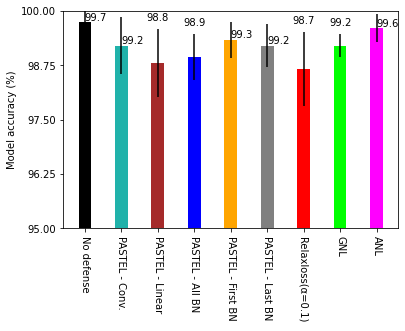

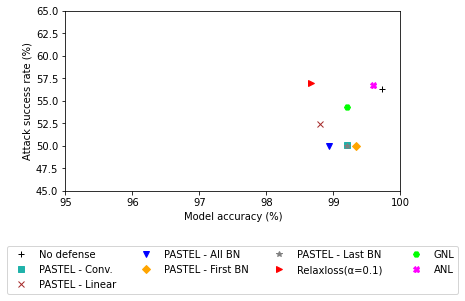

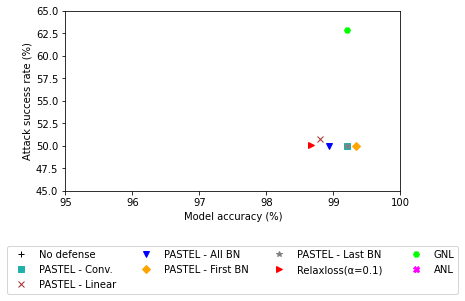

err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0


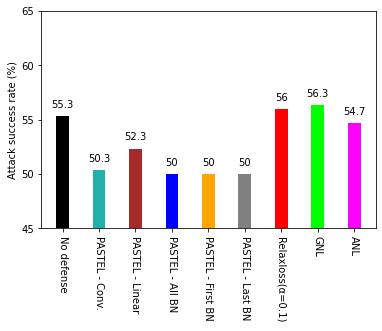

err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0


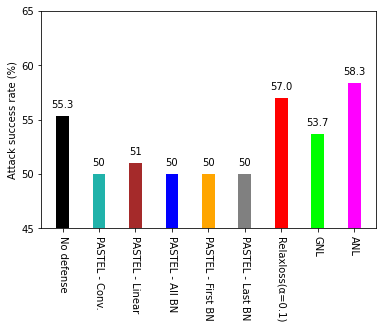

err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0


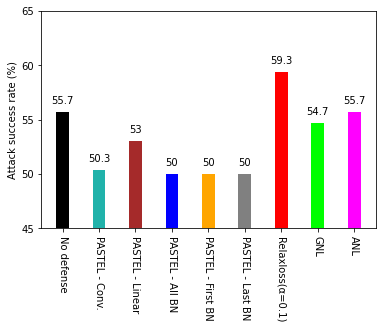

err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0


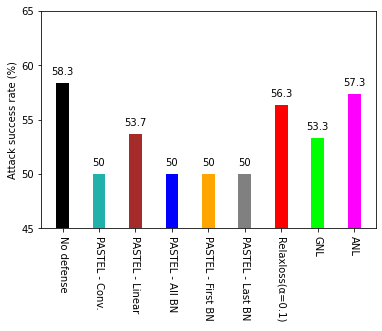

err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0


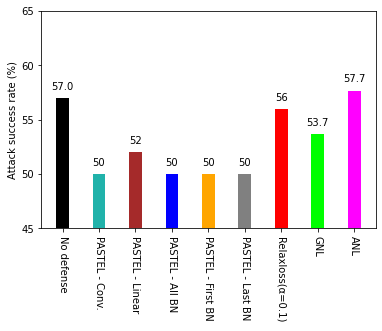

err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0


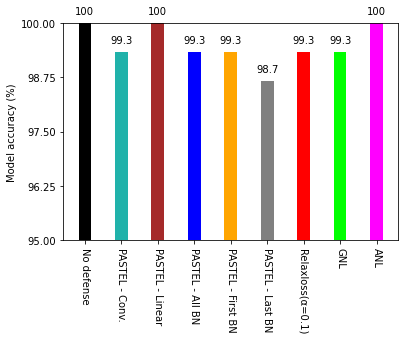

err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0


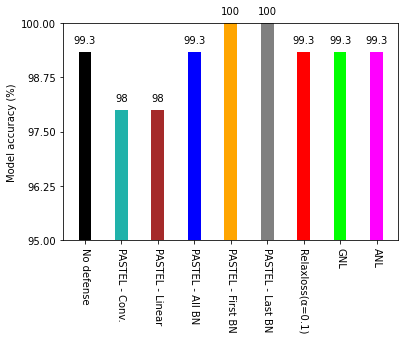

err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0


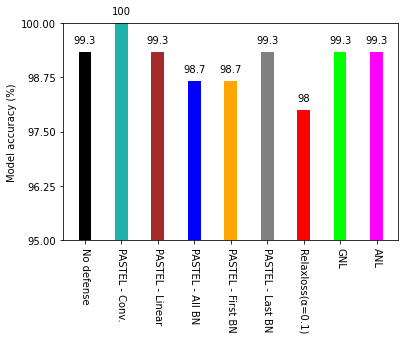

err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0


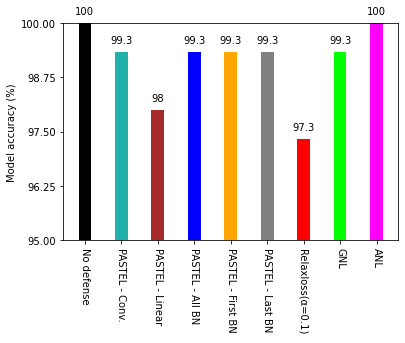

err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0


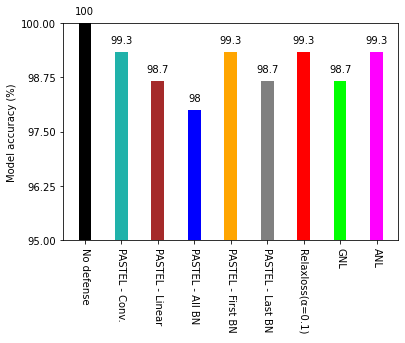

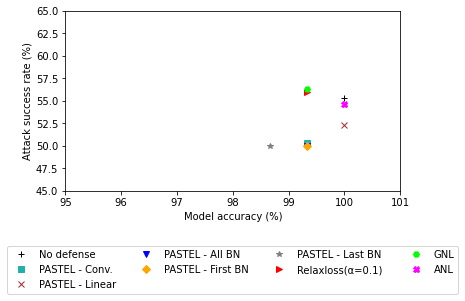

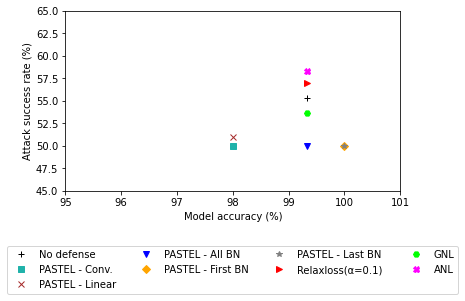

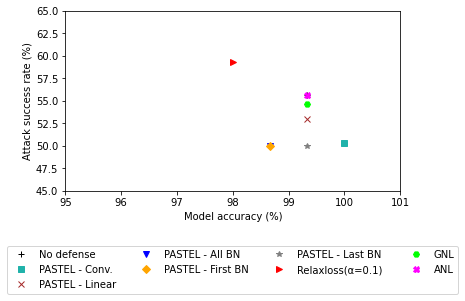

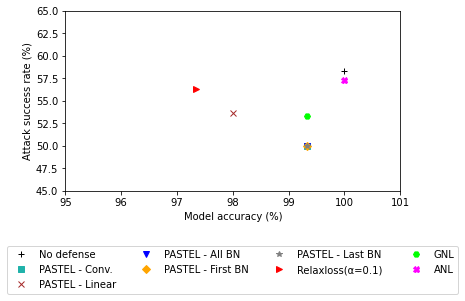

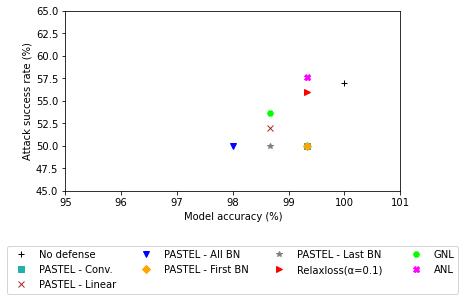

In [14]:
generate_histogram(plot_config, "local_model_attack_accuracy_hist", "Attack success rate (%)", "client_attack", 45, 65, average=True)
generate_histogram(plot_config, "global_model_attack_accuracy_hist", "Attack success rate (%)", "server_attack", 45, 70, average=True)
generate_xy_plot(plot_config, 'local_models_attack_accuracy', 'Attack success rate (%)', 'client_attack', 0, 100, average=True)
generate_xy_plot(plot_config, 'global_model_attack_accuracy', 'Attack success rate (%)', 'server_attack', 0, 100, average=True)
generate_xy_plot(plot_config, 'local_models_accuracy', 'Model accuracy (%)', 'client_accuracy', 0, 102, average=True)
generate_histogram(plot_config, "local_models_accuracy_hist", "Model accuracy (%)", "client_accuracy", 95, 100, average=True)
generate_tradeoff_plot(plot_config, 'attack_accuracy_tradeoff', 'Model accuracy (%)', 'Attack success rate (%)', 'client_accuracy', 'client_attack', 45, 65, 95, 100, average=True)
generate_tradeoff_plot(plot_config, 'attack_accuracy_tradeoff_server', 'Model accuracy (%)', 'Attack success rate (%)', 'client_accuracy', 'server_attack', 45, 65, 95, 100, average=True)

generate_histogram(plot_config, "local_model_0_attack_accuracy_hist", "Attack success rate (%)", "client_attack_0", 45, 65, average=True, extension = "png")
generate_histogram(plot_config, "local_model_1_attack_accuracy_hist", "Attack success rate (%)", "client_attack_1", 45, 65, average=True, extension = "png")
generate_histogram(plot_config, "local_model_2_attack_accuracy_hist", "Attack success rate (%)", "client_attack_2", 45, 65, average=True, extension = "png")
generate_histogram(plot_config, "local_model_3_attack_accuracy_hist", "Attack success rate (%)", "client_attack_3", 45, 65, average=True, extension = "png")
generate_histogram(plot_config, "local_model_4_attack_accuracy_hist", "Attack success rate (%)", "client_attack_4", 45, 65, average=True, extension = "png")


generate_histogram(plot_config, "local_model_0_accuracy_hist", "Model accuracy (%)", "client_accuracy_0", 95, 100, average=True, extension = "png")
generate_histogram(plot_config, "local_model_1_accuracy_hist", "Model accuracy (%)", "client_accuracy_1", 95, 100, average=True, extension = "png")
generate_histogram(plot_config, "local_model_2_accuracy_hist", "Model accuracy (%)", "client_accuracy_2", 95, 100, average=True, extension = "png")
generate_histogram(plot_config, "local_model_3_accuracy_hist", "Model accuracy (%)", "client_accuracy_3", 95, 100, average=True, extension = "png")
generate_histogram(plot_config, "local_model_4_accuracy_hist", "Model accuracy (%)", "client_accuracy_4", 95, 100, average=True, extension = "png")

generate_tradeoff_plot(plot_config, 'attack_accuracy_tradeoff_client1', 'Model accuracy (%)', 'Attack success rate (%)', 'client_accuracy_0', 'client_attack_0', 45, 65, 95, 101, average=True)
generate_tradeoff_plot(plot_config, 'attack_accuracy_tradeoff_client2', 'Model accuracy (%)', 'Attack success rate (%)', 'client_accuracy_1', 'client_attack_1', 45, 65, 95, 101, average=True)
generate_tradeoff_plot(plot_config, 'attack_accuracy_tradeoff_client3', 'Model accuracy (%)', 'Attack success rate (%)', 'client_accuracy_2', 'client_attack_2', 45, 65, 95, 101, average=True)
generate_tradeoff_plot(plot_config, 'attack_accuracy_tradeoff_client4', 'Model accuracy (%)', 'Attack success rate (%)', 'client_accuracy_3', 'client_attack_3', 45, 65, 95, 101, average=True)
generate_tradeoff_plot(plot_config, 'attack_accuracy_tradeoff_client5', 'Model accuracy (%)', 'Attack success rate (%)', 'client_accuracy_4', 'client_attack_4', 45, 65, 95, 101, average=True)



### CelebA ResNet20

In [15]:
plot_config = {
                "dataset_name": "celeba_resnet",
                "dataset_pretty_name" : "CelebA_ResNet",

                "data":[

                        {
                            "exp_name" : "No defense",
                            "file_path": "ppm_baseline_celeba_resnet.csv",
                            "color": "black",
                            "symbol" : "+"
                        },
                    
                                                 {
                            "exp_name" : "PASTEL - Conv.",
                            "file_path": "ppm_conv_celeba_resnet.csv",
                            "color": "lightseagreen",
                            "symbol" : "s"
                        },
                                                                     {
                            "exp_name" : "PASTEL - Linear",
                            "file_path": "ppm_linear_celeba_resnet.csv",
                            "color": "brown",
                            "symbol" : "x"
                        },
                                                                     {
                            "exp_name" : "PASTEL - All BN",
                            "file_path": "ppm_allbn_celeba_resnet.csv",
                            "color": "blue",
                            "symbol" : "v"
                        },
                                                                  {
                            "exp_name" : "PASTEL - First BN",
                            "file_path": "ppm_firstbn_celeba_resnet.csv",
                            "color": "orange",
                            "symbol" : "D"
                        },
                                              {
                            "exp_name" : "PASTEL - Last BN",
                            "file_path": "ppm_lastbn_celeba_resnet.csv",
                            "color": "grey",
                            "symbol" : "*"
                        },
                                                                                         {
                            "exp_name" : "Relaxloss(α=0.1)",
                            "file_path": "ppm_relaxloss_alpha01_celeba_resnet.csv",
                            "color": "red",
                            "symbol" : ">"
                        },
#                                                                      {
#                             "exp_name" : "Relaxloss(α=0.3)",
#                             "file_path": "ppm_relaxloss_celeba_resnet.csv",
#                             "color": "red",
#                             "symbol" : ">"
#                         },
                                                                     {
                            "exp_name" : "GNL",
                            "file_path": "ppm_gnl_celeba_resnet.csv",
                            "color": "lime",
                            "symbol" : "H"
                        },

                                                                         {
                            "exp_name" : "ANL",
                            "file_path": "ppm_anl_celeba_resnet.csv",
                            "color": "magenta",
                            "symbol" : "X"
                        }
                    ]
                }

err
1.9708993998792645
err
0.942809041582063
err
0.8692269873603506
err
0.0
err
0.0
err
0.0
err
1.1274356350191832
err
1.2472191289246468
err
1.062491830033951


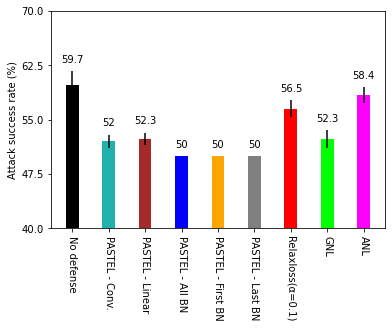

err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0


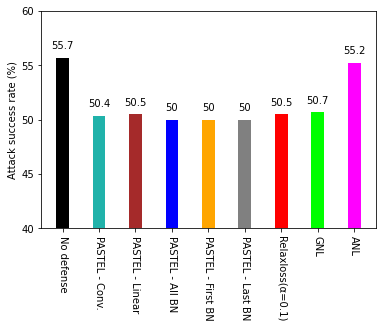

No defense
50
PASTEL - Conv.
50
PASTEL - Linear
50
PASTEL - All BN
50
PASTEL - First BN
50
PASTEL - Last BN
50
Relaxloss(α=0.1)
50
GNL
50
ANL
50


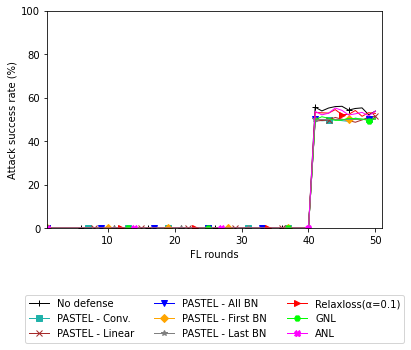

No defense
50
PASTEL - Conv.
50
PASTEL - Linear
50
PASTEL - All BN
50
PASTEL - First BN
50
PASTEL - Last BN
50
Relaxloss(α=0.1)
50
GNL
50
ANL
50


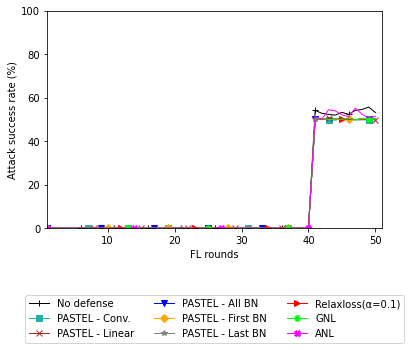

No defense
50
PASTEL - Conv.
50
PASTEL - Linear
50
PASTEL - All BN
50
PASTEL - First BN
50
PASTEL - Last BN
50
Relaxloss(α=0.1)
50
GNL
50
ANL
50


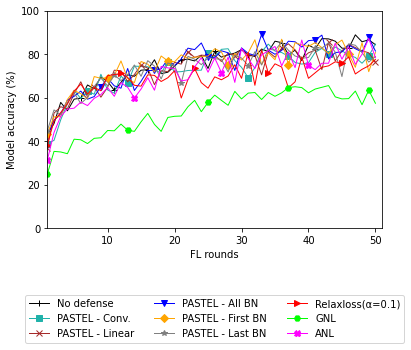

err
0.6531972647421923
err
0.8844332774281034
err
1.1469767022723616
err
0.5333333333333358
err
0.7302967433402214
err
1.5549205052920918
err
1.3984117975601986
err
1.2649110640673502
err
1.5434449203720304


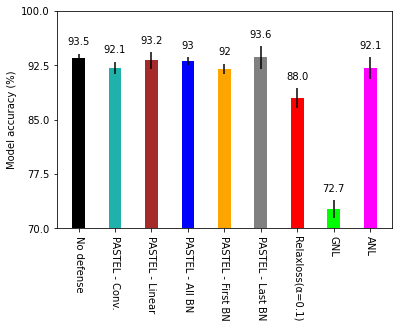

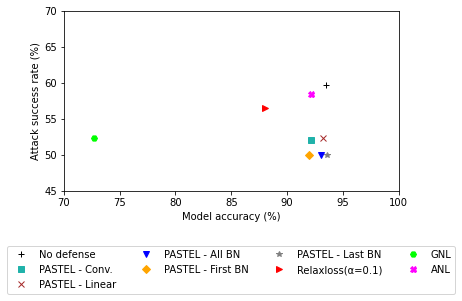

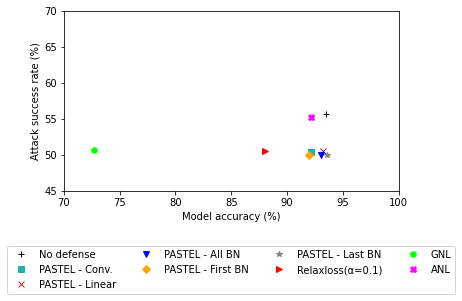

err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0


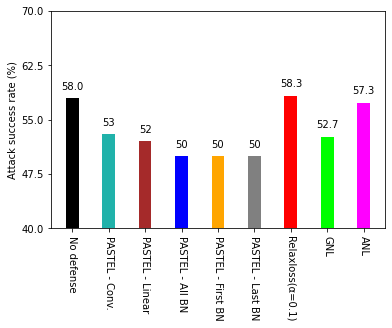

err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0


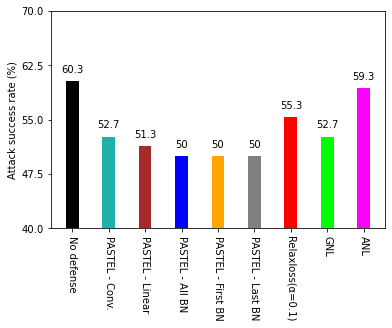

err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0


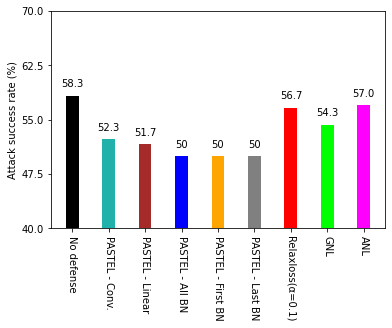

err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0


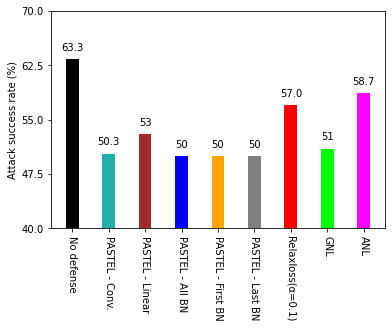

err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0


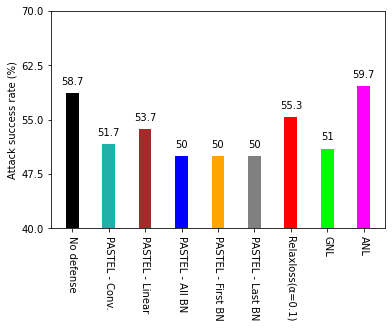

err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0


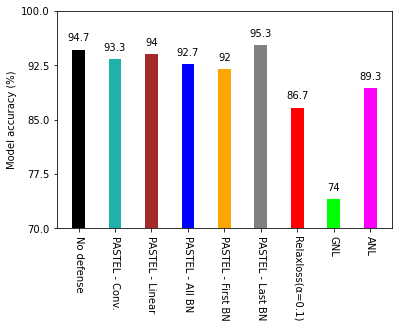

err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0


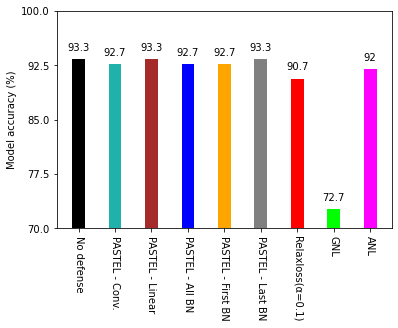

err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0


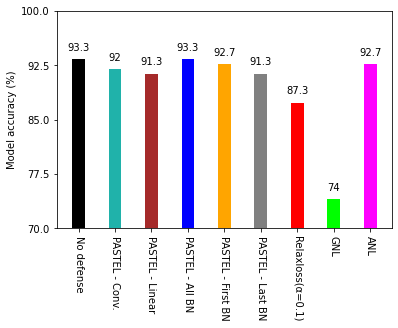

err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0


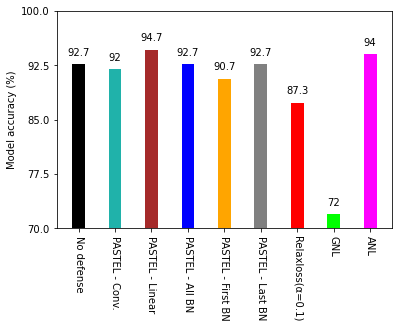

err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0


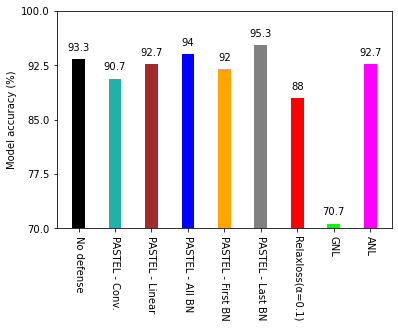

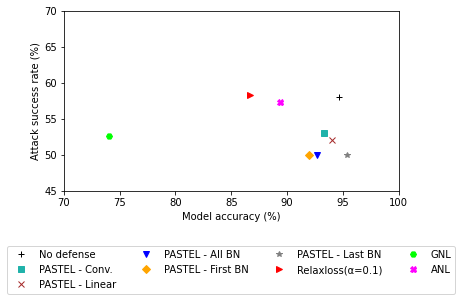

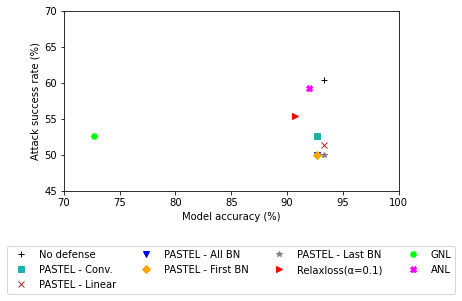

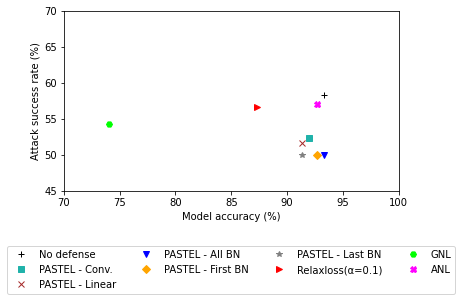

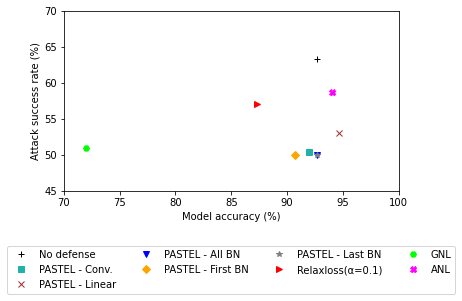

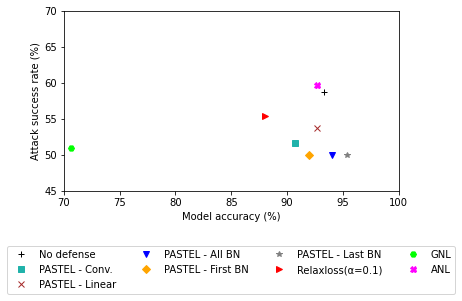

In [16]:
generate_histogram(plot_config, "local_model_attack_accuracy_hist", "Attack success rate (%)", "client_attack", 40, 70, average=True)
generate_histogram(plot_config, "global_model_attack_accuracy_hist", "Attack success rate (%)", "server_attack", 40, 60, average=True)
generate_xy_plot(plot_config, 'local_models_attack_accuracy', 'Attack success rate (%)', 'client_attack', 0, 100, average=True)
generate_xy_plot(plot_config, 'global_model_attack_accuracy', 'Attack success rate (%)', 'server_attack', 0, 100, average=True)
generate_xy_plot(plot_config, 'local_models_accuracy', 'Model accuracy (%)', 'client_accuracy', 0, 100, average=True)
generate_histogram(plot_config, "local_models_accuracy_hist", "Model accuracy (%)", "client_accuracy", 70, 100, average=True)
generate_tradeoff_plot(plot_config, 'attack_accuracy_tradeoff_client', 'Model accuracy (%)', 'Attack success rate (%)', 'client_accuracy', 'client_attack', 45, 70, 70, 100, average=True)
generate_tradeoff_plot(plot_config, 'attack_accuracy_tradeoff_server', 'Model accuracy (%)', 'Attack success rate (%)', 'client_accuracy', 'server_attack', 45, 70, 70, 100, average=True)

generate_histogram(plot_config, "local_model_0_attack_accuracy_hist", "Attack success rate (%)", "client_attack_0", 40, 70, average=True, extension = "png")
generate_histogram(plot_config, "local_model_1_attack_accuracy_hist", "Attack success rate (%)", "client_attack_1", 40, 70, average=True, extension = "png")
generate_histogram(plot_config, "local_model_2_attack_accuracy_hist", "Attack success rate (%)", "client_attack_2", 40, 70, average=True, extension = "png")
generate_histogram(plot_config, "local_model_3_attack_accuracy_hist", "Attack success rate (%)", "client_attack_3", 40, 70, average=True, extension = "png")
generate_histogram(plot_config, "local_model_4_attack_accuracy_hist", "Attack success rate (%)", "client_attack_4", 40, 70, average=True, extension = "png")


generate_histogram(plot_config, "local_model_0_accuracy_hist", "Model accuracy (%)", "client_accuracy_0", 70, 100, average=True, extension = "png")
generate_histogram(plot_config, "local_model_1_accuracy_hist", "Model accuracy (%)", "client_accuracy_1", 70, 100, average=True, extension = "png")
generate_histogram(plot_config, "local_model_2_accuracy_hist", "Model accuracy (%)", "client_accuracy_2", 70, 100, average=True, extension = "png")
generate_histogram(plot_config, "local_model_3_accuracy_hist", "Model accuracy (%)", "client_accuracy_3", 70, 100, average=True, extension = "png")
generate_histogram(plot_config, "local_model_4_accuracy_hist", "Model accuracy (%)", "client_accuracy_4", 70, 100, average=True, extension = "png")

generate_tradeoff_plot(plot_config, 'attack_accuracy_tradeoff_client1', 'Model accuracy (%)', 'Attack success rate (%)', 'client_accuracy_0', 'client_attack_0', 45, 70, 70, 100, average=True)
generate_tradeoff_plot(plot_config, 'attack_accuracy_tradeoff_client2', 'Model accuracy (%)', 'Attack success rate (%)', 'client_accuracy_1', 'client_attack_1', 45, 70, 70, 100, average=True)
generate_tradeoff_plot(plot_config, 'attack_accuracy_tradeoff_client3', 'Model accuracy (%)', 'Attack success rate (%)', 'client_accuracy_2', 'client_attack_2', 45, 70, 70, 100, average=True)
generate_tradeoff_plot(plot_config, 'attack_accuracy_tradeoff_client4', 'Model accuracy (%)', 'Attack success rate (%)', 'client_accuracy_3', 'client_attack_3', 45, 70, 70, 100, average=True)
generate_tradeoff_plot(plot_config, 'attack_accuracy_tradeoff_client5', 'Model accuracy (%)', 'Attack success rate (%)', 'client_accuracy_4', 'client_attack_4', 45, 70, 70, 100, average=True)


### GTSRB - ResNet

In [23]:
plot_config = {
                "dataset_name": "GTSRB_resnet",
                "dataset_pretty_name" : "GTSRB_ResNet",

                "data":[

                        {
                            "exp_name" : "No defense",
                            "file_path": "ppm_baseline_gtsrb_resnet.csv",
                            "color": "black",
                            "symbol" : "+"
                        },
                    
                                                 {
                            "exp_name" : "PASTEL - Conv.",
                            "file_path": "ppm_conv_gtsrb_resnet.csv",
                            "color": "lightseagreen",
                            "symbol" : "s"
                        },
                                                                     {
                            "exp_name" : "PASTEL - Linear",
                            "file_path": "ppm_linear_gtsrb_resnet.csv",
                            "color": "brown",
                            "symbol" : "x"
                        },
                                                                     {
                            "exp_name" : "PASTEL - All BN",
                            "file_path": "ppm_all-bn_gtsrb_resnet.csv",
                            "color": "blue",
                            "symbol" : "v"
                        },
                                                                  {
                            "exp_name" : "PASTEL - First BN",
                            "file_path": "ppm_first-bn_gtsrb_resnet.csv",
                            "color": "orange",
                            "symbol" : "D"
                        },
                                              {
                            "exp_name" : "PASTEL - Last BN",
                            "file_path": "ppm_last-bn_gtsrb_resnet.csv",
                            "color": "grey",
                            "symbol" : "*"
                        },
                                                          {
                            "exp_name" : "Relaxloss(α=0.3)",
                            "file_path": "ppm_relaxloss03_gtsrb_resnet.csv",
                            "color": "red",
                            "symbol" : ">"
                        },

                        {
                            "exp_name" : "GNL",
                            "file_path": "ppm_gnl_gtsrb_resnet.csv",
                            "color": "lime",
                            "symbol" : "H"
                        },

#                                                                          {
#                             "exp_name" : "ANL",
#                             "file_path": "ppm_anl_gtsrb_resnet.csv",
#                             "color": "magenta",
#                             "symbol" : "X"
#                         }
                    ]
                }

err
1.2300305681964547
err
0.6540020849034013
err
0.7909604519773975
err
0.0
err
0.0
err
0.0
err
1.4580212317021413
err
1.4514387094536891
err
2.4781595705605977
err
0.3831824849223313


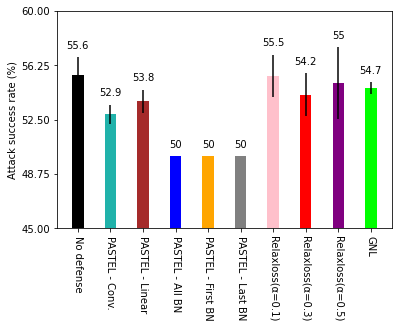

err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0


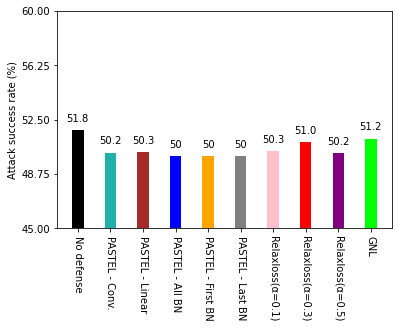

No defense
50
PASTEL - Conv.
50
PASTEL - Linear
50
PASTEL - All BN
50
PASTEL - First BN
50
PASTEL - Last BN
50
Relaxloss(α=0.1)
50
Relaxloss(α=0.3)
50
Relaxloss(α=0.5)
50
GNL
50


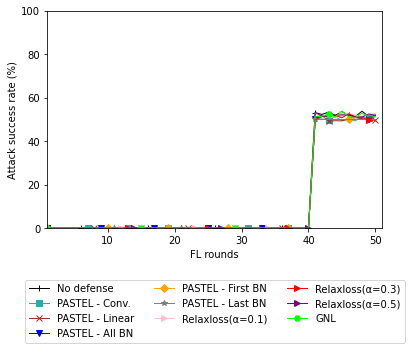

No defense
50
PASTEL - Conv.
50
PASTEL - Linear
50
PASTEL - All BN
50
PASTEL - First BN
50
PASTEL - Last BN
50
Relaxloss(α=0.1)
50
Relaxloss(α=0.3)
50
Relaxloss(α=0.5)
50
GNL
50


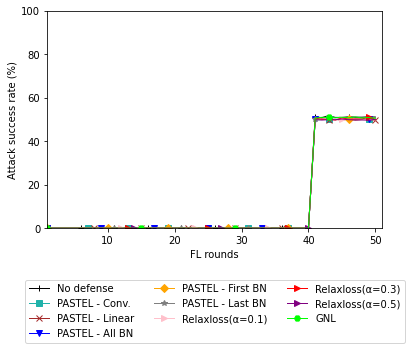

No defense
50
PASTEL - Conv.
50
PASTEL - Linear
50
PASTEL - All BN
50
PASTEL - First BN
50
PASTEL - Last BN
50
Relaxloss(α=0.1)
50
Relaxloss(α=0.3)
50
Relaxloss(α=0.5)
50
GNL
50


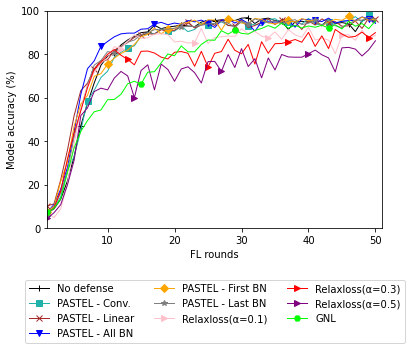

err
0.8303355060281885
err
0.6188955452035719
err
0.2767785020093915
err
0.4519774011299319
err
0.9039548022598837
err
0.972014154468085
err
1.4022230108464255
err
1.7505009474383812
err
1.0955208717324978
err
1.1071140080375954


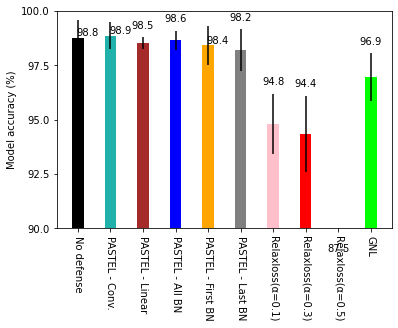

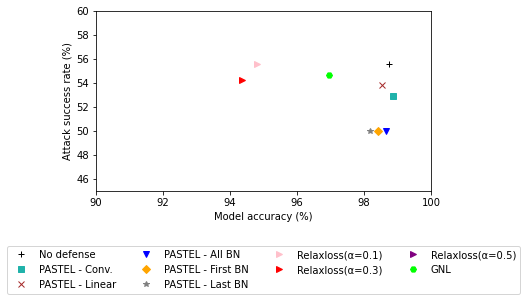

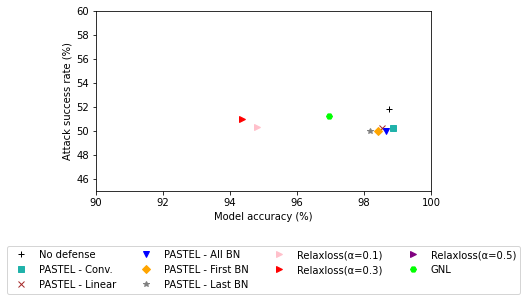

err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0


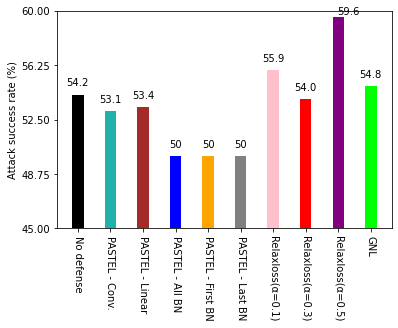

err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0


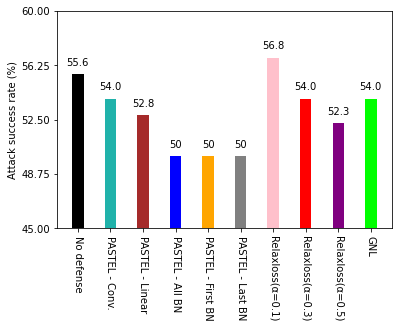

err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0


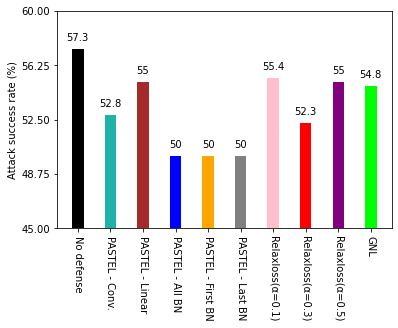

err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0


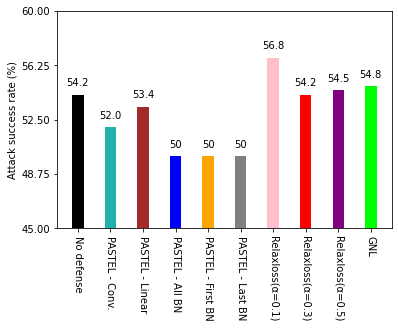

err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0


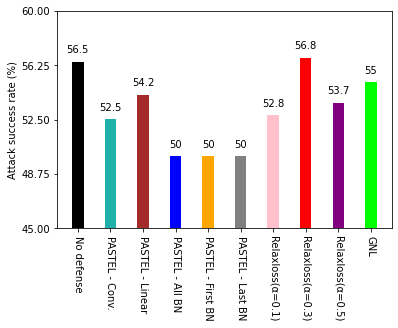

err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0


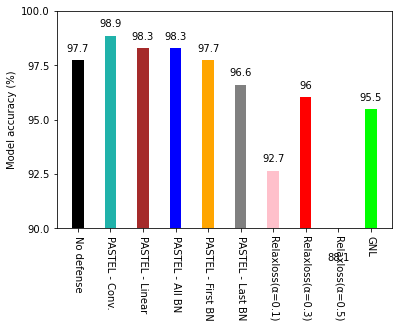

err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0


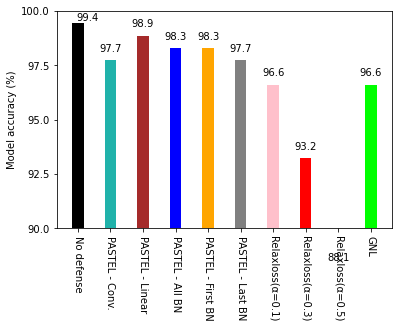

err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0


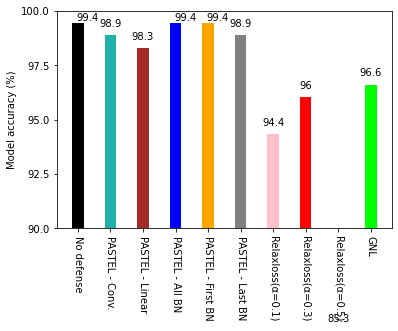

err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0


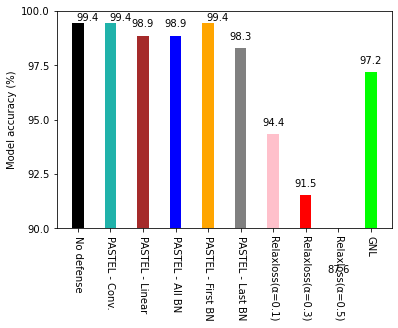

err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0


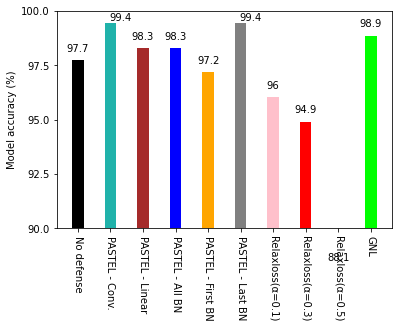

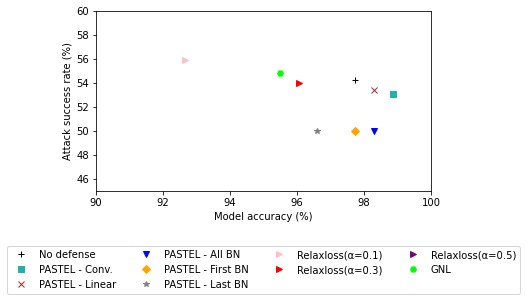

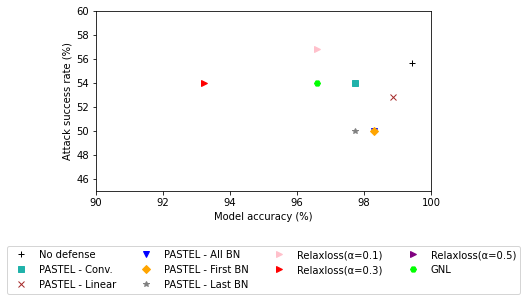

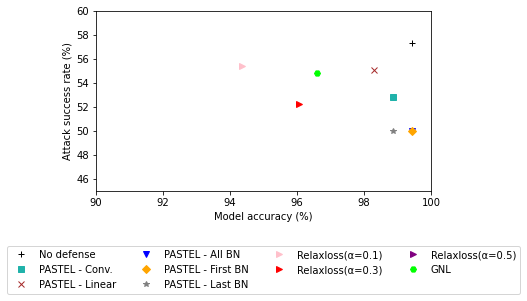

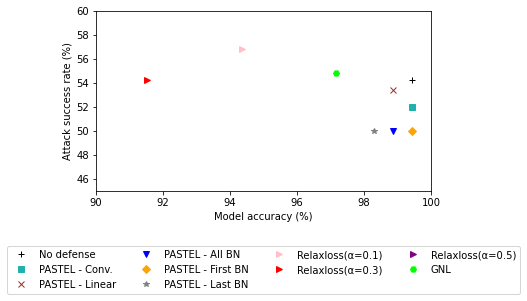

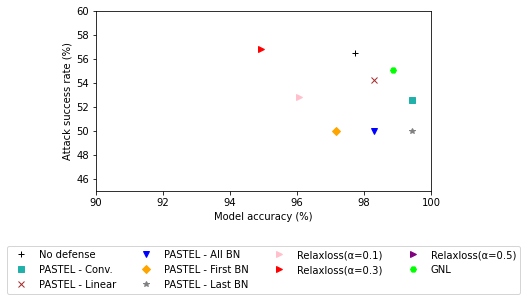

In [24]:
generate_histogram(plot_config, "local_model_attack_accuracy_hist", "Attack success rate (%)", "client_attack", 45, 60, average=True)
generate_histogram(plot_config, "global_model_attack_accuracy_hist", "Attack success rate (%)", "server_attack", 45, 60, average=True)
generate_xy_plot(plot_config, 'local_models_attack_accuracy', 'Attack success rate (%)', 'client_attack', 0, 100, average=True)
generate_xy_plot(plot_config, 'global_model_attack_accuracy', 'Attack success rate (%)', 'server_attack', 0, 100, average=True)
generate_xy_plot(plot_config, 'local_models_accuracy', 'Model accuracy (%)', 'client_accuracy', 0, 100, average=True)
generate_histogram(plot_config, "local_models_accuracy_hist", "Model accuracy (%)", "client_accuracy", 90, 100, average=True)
generate_tradeoff_plot(plot_config, 'attack_accuracy_tradeoff_client', 'Model accuracy (%)', 'Attack success rate (%)', 'client_accuracy', 'client_attack', 45, 60, 90, 100, average=True)
generate_tradeoff_plot(plot_config, 'attack_accuracy_tradeoff_server', 'Model accuracy (%)', 'Attack success rate (%)', 'client_accuracy', 'server_attack', 45, 60, 90, 100, average=True)

generate_histogram(plot_config, "local_model_0_attack_accuracy_hist", "Attack success rate (%)", "client_attack_0", 45, 60, average=True, extension = "png")
generate_histogram(plot_config, "local_model_1_attack_accuracy_hist", "Attack success rate (%)", "client_attack_1", 45, 60, average=True, extension = "png")
generate_histogram(plot_config, "local_model_2_attack_accuracy_hist", "Attack success rate (%)", "client_attack_2", 45, 60, average=True, extension = "png")
generate_histogram(plot_config, "local_model_3_attack_accuracy_hist", "Attack success rate (%)", "client_attack_3", 45, 60, average=True, extension = "png")
generate_histogram(plot_config, "local_model_4_attack_accuracy_hist", "Attack success rate (%)", "client_attack_4", 45, 60, average=True, extension = "png")


generate_histogram(plot_config, "local_model_0_accuracy_hist", "Model accuracy (%)", "client_accuracy_0", 90, 100, average=True, extension = "png")
generate_histogram(plot_config, "local_model_1_accuracy_hist", "Model accuracy (%)", "client_accuracy_1", 90, 100, average=True, extension = "png")
generate_histogram(plot_config, "local_model_2_accuracy_hist", "Model accuracy (%)", "client_accuracy_2", 90, 100, average=True, extension = "png")
generate_histogram(plot_config, "local_model_3_accuracy_hist", "Model accuracy (%)", "client_accuracy_3", 90, 100, average=True, extension = "png")
generate_histogram(plot_config, "local_model_4_accuracy_hist", "Model accuracy (%)", "client_accuracy_4", 90, 100, average=True, extension = "png")

generate_tradeoff_plot(plot_config, 'attack_accuracy_tradeoff_client1', 'Model accuracy (%)', 'Attack success rate (%)', 'client_accuracy_0', 'client_attack_0', 45, 60, 90, 100, average=True)
generate_tradeoff_plot(plot_config, 'attack_accuracy_tradeoff_client2', 'Model accuracy (%)', 'Attack success rate (%)', 'client_accuracy_1', 'client_attack_1', 45, 60, 90, 100, average=True)
generate_tradeoff_plot(plot_config, 'attack_accuracy_tradeoff_client3', 'Model accuracy (%)', 'Attack success rate (%)', 'client_accuracy_2', 'client_attack_2', 45, 60, 90, 100, average=True)
generate_tradeoff_plot(plot_config, 'attack_accuracy_tradeoff_client4', 'Model accuracy (%)', 'Attack success rate (%)', 'client_accuracy_3', 'client_attack_3', 45, 60, 90, 100, average=True)
generate_tradeoff_plot(plot_config, 'attack_accuracy_tradeoff_client5', 'Model accuracy (%)', 'Attack success rate (%)', 'client_accuracy_4', 'client_attack_4', 45, 60, 90, 100, average=True)


### GTSRB - VGG

In [34]:
plot_config = {
                "dataset_name": "GTSRB_vgg",
                "dataset_pretty_name" : "GTSRB_VGG",

                "data":[

                        {
                            "exp_name" : "No defense",
                            "file_path": "ppm_baseline_gtsrb_vgg.csv",
                            "color": "black",
                            "symbol" : "+"
                        },
                    
                                                 {
                            "exp_name" : "PASTEL - Conv.",
                            "file_path": "ppm_conv_gtsrb_vgg.csv",
                            "color": "lightseagreen",
                            "symbol" : "s"
                        },
                                                                     {
                            "exp_name" : "PASTEL - Linear",
                            "file_path": "ppm_linear_gtsrb_vgg.csv",
                            "color": "brown",
                            "symbol" : "x"
                        },
                                                                     {
                            "exp_name" : "PASTEL - All BN",
                            "file_path": "ppm_all-bn_gtsrb_vgg.csv",
                            "color": "blue",
                            "symbol" : "v"
                        },
                                                                  {
                            "exp_name" : "PASTEL - First BN",
                            "file_path": "ppm_first-bn_gtsrb_vgg.csv",
                            "color": "orange",
                            "symbol" : "D"
                        },
                                              {
                            "exp_name" : "PASTEL - Last BN",
                            "file_path": "ppm_last-bn_gtsrb_vgg.csv",
                            "color": "grey",
                            "symbol" : "*"
                        },
                                                                                         {
                            "exp_name" : "Relaxloss(α=0.3)",
                            "file_path": "ppm_relaxloss03_gtsrb_vgg.csv",
                            "color": "red",
                            "symbol" : ">"
                        },
                        {
                            "exp_name" : "GNL",
                            "file_path": "ppm_gnl_gtsrb_vgg.csv",
                            "color": "lime",
                            "symbol" : "H"
                        },

                                                                         {
                            "exp_name" : "ANL",
                            "file_path": "ppm_anl_gtsrb_vgg.csv",
                            "color": "magenta",
                            "symbol" : "X"
                        }
                    ]
                }

err
1.4248045438325976
err
2.1483789086815324
err
1.1071140080375934
err
0.0
err
0.0
err
0.0
err
1.6759770592306582
err
0.7011115054232105
err
1.6702537287112398


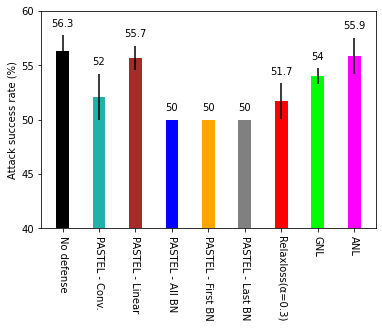

err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0


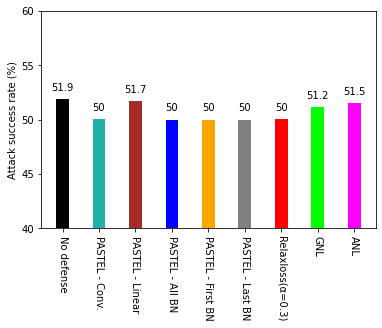

No defense
50
PASTEL - Conv.
50
PASTEL - Linear
50
PASTEL - All BN
50
PASTEL - First BN
50
PASTEL - Last BN
50
Relaxloss(α=0.3)
50
GNL
50
ANL
50


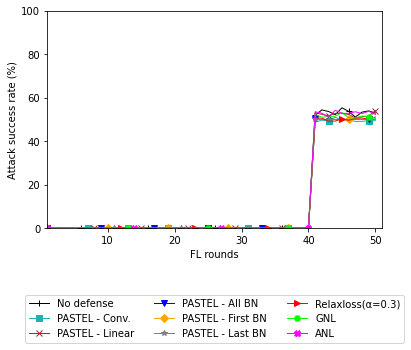

No defense
50
PASTEL - Conv.
50
PASTEL - Linear
50
PASTEL - All BN
50
PASTEL - First BN
50
PASTEL - Last BN
50
Relaxloss(α=0.3)
50
GNL
50
ANL
50


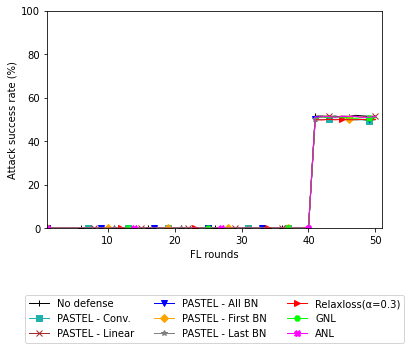

No defense
50
PASTEL - Conv.
50
PASTEL - Linear
50
PASTEL - All BN
50
PASTEL - First BN
50
PASTEL - Last BN
50
Relaxloss(α=0.3)
50
GNL
50
ANL
50


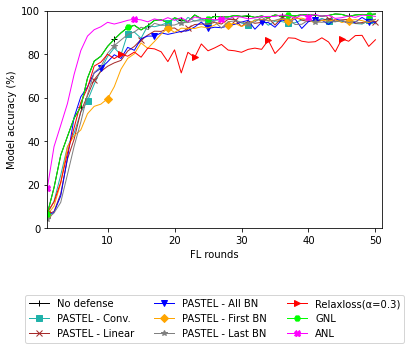

err
0.4227861453981867
err
0.7495197266339865
err
0.4519774011299546
err
0.6588646208864694
err
1.0478664966661815
err
1.3080041698068041
err
1.0955208717325107
err
0.4227861453981867
err
0.5761603970161269


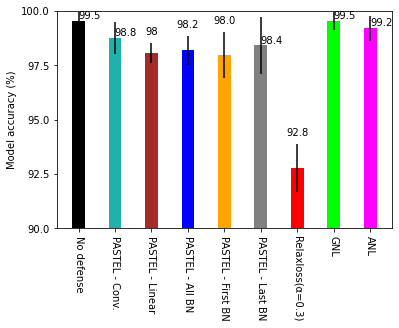

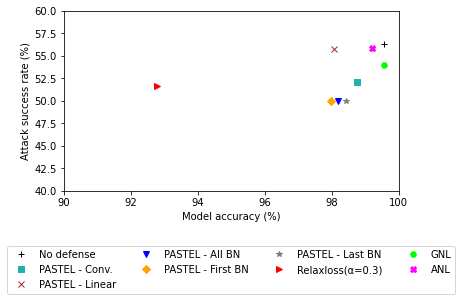

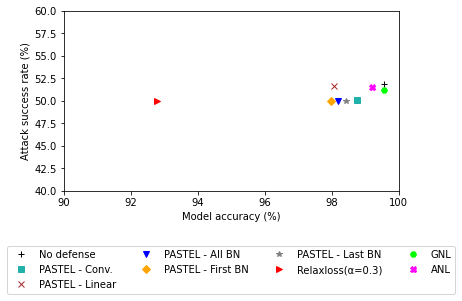

err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0


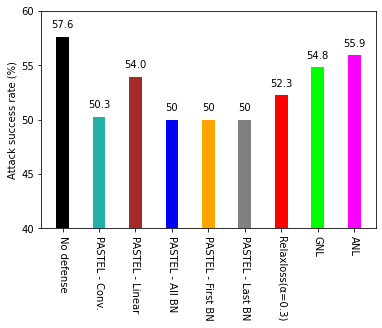

err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0


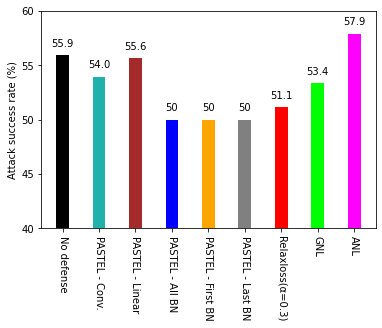

err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0


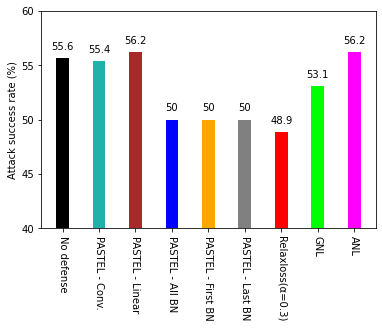

err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0


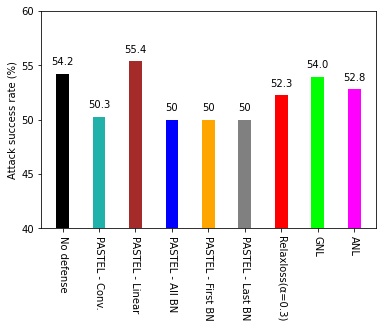

err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0


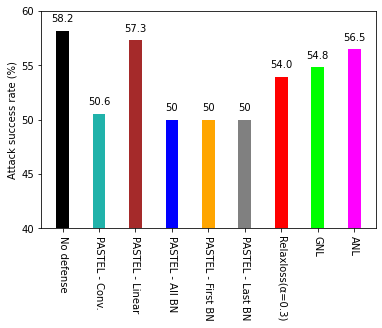

err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0


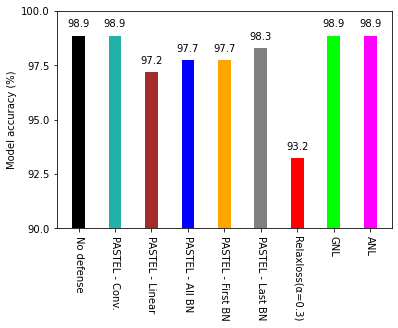

err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0


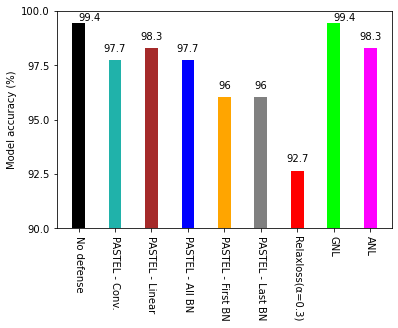

err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0


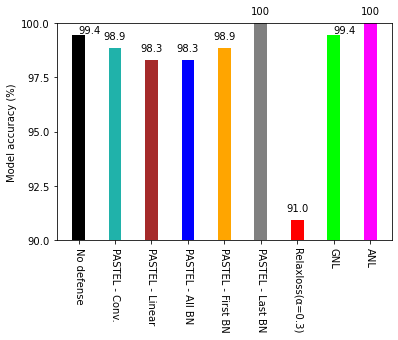

err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0


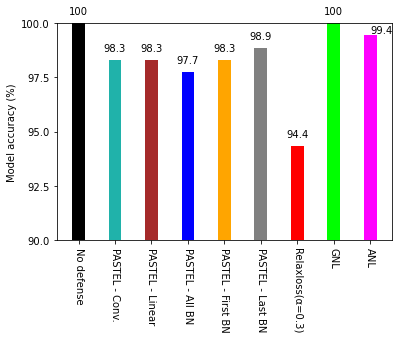

err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0
err
0.0


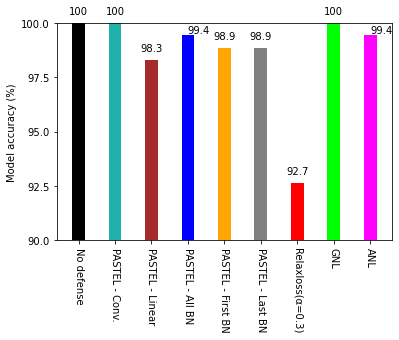

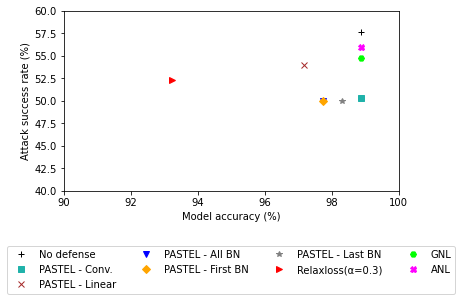

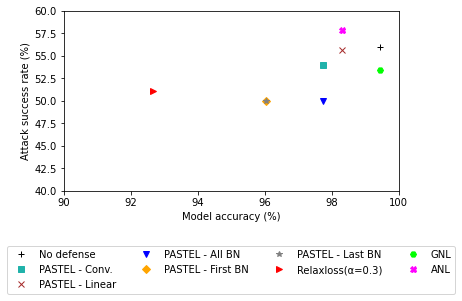

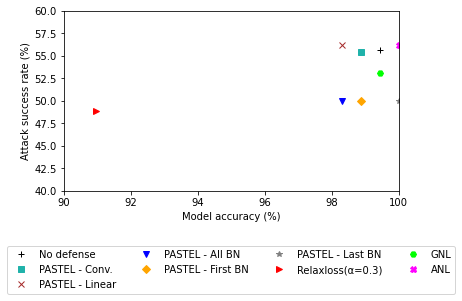

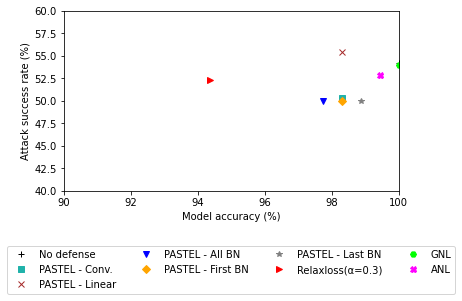

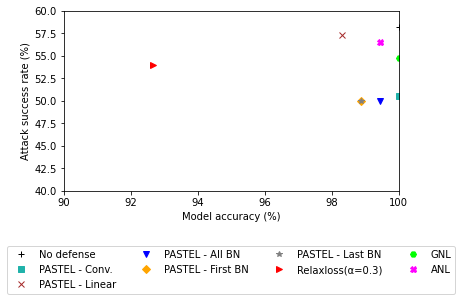

In [39]:
generate_histogram(plot_config, "local_model_attack_accuracy_hist", "Attack success rate (%)", "client_attack", 40, 60, average=True)
generate_histogram(plot_config, "global_model_attack_accuracy_hist", "Attack success rate (%)", "server_attack", 40, 60, average=True)
generate_xy_plot(plot_config, 'local_models_attack_accuracy', 'Attack success rate (%)', 'client_attack', 0, 100, average=True)
generate_xy_plot(plot_config, 'global_model_attack_accuracy', 'Attack success rate (%)', 'server_attack', 0, 100, average=True)
generate_xy_plot(plot_config, 'local_models_accuracy', 'Model accuracy (%)', 'client_accuracy', 0, 100, average=True)
generate_histogram(plot_config, "local_models_accuracy_hist", "Model accuracy (%)", "client_accuracy", 90, 100, average=True)
generate_tradeoff_plot(plot_config, 'attack_accuracy_tradeoff_client', 'Model accuracy (%)', 'Attack success rate (%)', 'client_accuracy', 'client_attack', 40, 60, 90, 100, average=True)
generate_tradeoff_plot(plot_config, 'attack_accuracy_tradeoff_server', 'Model accuracy (%)', 'Attack success rate (%)', 'client_accuracy', 'server_attack', 40, 60, 90, 100, average=True)

generate_histogram(plot_config, "local_model_0_attack_accuracy_hist", "Attack success rate (%)", "client_attack_0", 40, 60, average=True, extension = "png")
generate_histogram(plot_config, "local_model_1_attack_accuracy_hist", "Attack success rate (%)", "client_attack_1", 40, 60, average=True, extension = "png")
generate_histogram(plot_config, "local_model_2_attack_accuracy_hist", "Attack success rate (%)", "client_attack_2", 40, 60, average=True, extension = "png")
generate_histogram(plot_config, "local_model_3_attack_accuracy_hist", "Attack success rate (%)", "client_attack_3", 40, 60, average=True, extension = "png")
generate_histogram(plot_config, "local_model_4_attack_accuracy_hist", "Attack success rate (%)", "client_attack_4", 40, 60, average=True, extension = "png")


generate_histogram(plot_config, "local_model_0_accuracy_hist", "Model accuracy (%)", "client_accuracy_0", 90, 100, average=True, extension = "png")
generate_histogram(plot_config, "local_model_1_accuracy_hist", "Model accuracy (%)", "client_accuracy_1", 90, 100, average=True, extension = "png")
generate_histogram(plot_config, "local_model_2_accuracy_hist", "Model accuracy (%)", "client_accuracy_2", 90, 100, average=True, extension = "png")
generate_histogram(plot_config, "local_model_3_accuracy_hist", "Model accuracy (%)", "client_accuracy_3", 90, 100, average=True, extension = "png")
generate_histogram(plot_config, "local_model_4_accuracy_hist", "Model accuracy (%)", "client_accuracy_4", 90, 100, average=True, extension = "png")

generate_tradeoff_plot(plot_config, 'attack_accuracy_tradeoff_client1', 'Model accuracy (%)', 'Attack success rate (%)', 'client_accuracy_0', 'client_attack_0', 40, 60, 90, 100, average=True)
generate_tradeoff_plot(plot_config, 'attack_accuracy_tradeoff_client2', 'Model accuracy (%)', 'Attack success rate (%)', 'client_accuracy_1', 'client_attack_1', 40, 60, 90, 100, average=True)
generate_tradeoff_plot(plot_config, 'attack_accuracy_tradeoff_client3', 'Model accuracy (%)', 'Attack success rate (%)', 'client_accuracy_2', 'client_attack_2', 40, 60, 90, 100, average=True)
generate_tradeoff_plot(plot_config, 'attack_accuracy_tradeoff_client4', 'Model accuracy (%)', 'Attack success rate (%)', 'client_accuracy_3', 'client_attack_3', 40, 60, 90, 100, average=True)
generate_tradeoff_plot(plot_config, 'attack_accuracy_tradeoff_client5', 'Model accuracy (%)', 'Attack success rate (%)', 'client_accuracy_4', 'client_attack_4', 40, 60, 90, 100, average=True)
